In [17]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [18]:
%matplotlib inline

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import tfomics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
import seqexplainer

# Get model and data

In [3]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

In [4]:
plant_promoter = eu.models.Hybrid.load_from_checkpoint("/cellar/users/aklie/projects/SeqExplainer/models/jores21/PlantPromoter.ckpt")
sdata = eu.datasets.jores21(dataset="leaf")
sdata_test = sdata[sdata["set"] == "test"]
eu.pp.ohe_seqs_sdata(sdata_test)
del sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.


One-hot encoding sequences:   0%|          | 0/7154 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 7154 ohe_seqs added


# Get attributions

In [5]:
explains = seqexplainer.attribute_on_batch(
    model=plant_promoter,
    inputs=torch.tensor(sdata_test.ohe_seqs, dtype=torch.float32),
    method="GradientShap",
    reference_type="dinuc_shuffle",
    target=0,
    device="cuda",
    batch_size=128
)

Computing feature attributions on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

In [6]:
explains.shape

torch.Size([7154, 4, 170])

# Dim reduce

In [7]:
from seqexplainer._tools import pca, umap
from seqexplainer._plot import pca_plot, umap_plot, skree_plot

In [46]:
explains_np = explains.detach().cpu().numpy()
contr = explains_np*sdata_test.ohe_seqs
oned_contr = contr.sum(axis=1)

In [50]:
pca_obj, pc_df = pca(oned_contr)

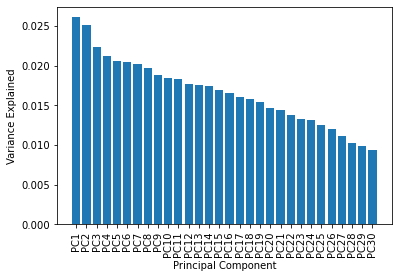

In [55]:
var_exp = skree_plot(pca_obj)

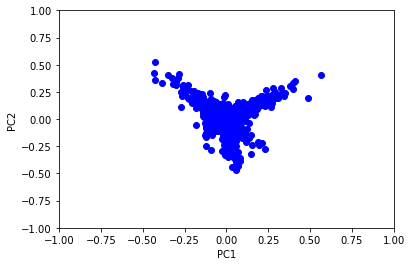

In [72]:
fig, ax = plt.subplots()
ax = pca_plot(pc_df.values)
plt.show()

In [68]:
umap_obj, umap_df = umap(pc_df.values)

Make sure your matrix is sample by feature


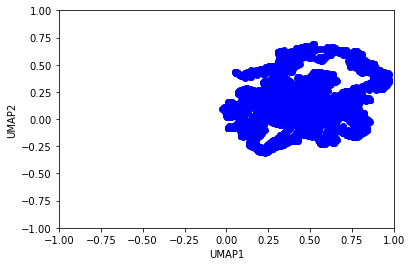

In [73]:
fig, ax = plt.subplots()
ax = umap_plot(umap_df.values)
plt.show()

# Modisco

In [8]:
from seqexplainer._attribution_analysis import modisco, modisco_logos, modisco_tomtom, modisco_report

In [36]:
modisco_out = "/cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out"

## Run modisco

In [11]:
seqs = sdata_test.ohe_seqs
hypo_imps = explains.detach().cpu().numpy()

In [12]:
pos_seqlets, neg_seqlets = modisco(
    one_hot=seqs,
    hypothetical_contribs=hypo_imps,
    output_dir=modisco_out,
    output_name="modisco2.h5",
)

Output directory already exists: /cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out


In [13]:
len(pos_seqlets), len(neg_seqlets)

(1, 12)

In [24]:
test_seqletset = pos_seqlets[0]

In [31]:
test_seqletset.contrib_scores.shape

(30, 4)

In [28]:
test_seqlet = test_seqletset.seqlets[0]

In [35]:
modisco_dict = seqexplainer.modisco_extract(
    pos_patterns=pos_seqlets,
    neg_patterns=neg_seqlets
)

In [33]:
modisco_out

{'pos_patterns': {'pattern_0': {'ppm': array([[0.24262735, 0.269437  , 0.24262735, 0.24530831],
          [0.21313673, 0.230563  , 0.24396783, 0.31233244],
          [0.25871314, 0.2613941 , 0.24932976, 0.230563  ],
          [0.21849866, 0.269437  , 0.23458445, 0.27747989],
          [0.24798928, 0.26809651, 0.22788204, 0.25603217],
          [0.21447721, 0.26809651, 0.23726542, 0.28016086],
          [0.24128686, 0.27077748, 0.23324397, 0.25469169],
          [0.19436997, 0.28016086, 0.25201072, 0.27345845],
          [0.23592493, 0.26541555, 0.26541555, 0.23324397],
          [0.19436997, 0.26675603, 0.21179625, 0.32707775],
          [0.23324397, 0.25067024, 0.26005362, 0.25603217],
          [0.18632708, 0.24798928, 0.14745308, 0.41823056],
          [0.33512064, 0.25871314, 0.0844504 , 0.32171582],
          [0.0308311 , 0.02010724, 0.00402145, 0.94504021],
          [0.95040214, 0.        , 0.        , 0.04959786],
          [0.14879357, 0.02815013, 0.00134048, 0.82171582],
    

In [38]:
modisco_h5_file = os.path.join(modisco_out, "modisco2.h5")
modisco_load = seqexplainer.modisco_load_h5(modisco_h5_file)

In [43]:
np.all(modisco_dict["pos_patterns"]["pattern_0"]["ppm"] == modisco_load["pos_patterns"]["pattern_0"]["ppm"])

True

In [44]:
np.all(modisco_dict["pos_patterns"]["pattern_0"]["seqlet_set"][0] == modisco_load["pos_patterns"]["pattern_0"]["seqlet_set"][0])

True

## Create logos

In [101]:
logo_names = modisco_logos(
    os.path.join(modisco_out, "modisco.h5"),
    output_dir=os.path.join(modisco_out, "logos"),
)

Output directory already exists: /cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out/logos


In [103]:
logo_names

['pos_patterns.pattern_0',
 'pos_patterns.pattern_1',
 'neg_patterns.pattern_0',
 'neg_patterns.pattern_1',
 'neg_patterns.pattern_2',
 'neg_patterns.pattern_3',
 'neg_patterns.pattern_4',
 'neg_patterns.pattern_5',
 'neg_patterns.pattern_6',
 'neg_patterns.pattern_7',
 'neg_patterns.pattern_8',
 'neg_patterns.pattern_9',
 'neg_patterns.pattern_10',
 'neg_patterns.pattern_11',
 'neg_patterns.pattern_12',
 'neg_patterns.pattern_13',
 'neg_patterns.pattern_14']

## Run motifs against database with tomtom

In [16]:
meme_db = "/cellar/users/aklie/data/eugene/jores21/CPEs.meme"

In [17]:
tomtom_exec="~/opt/meme/bin/tomtom"

In [18]:
tomtom_res = modisco_tomtom(
    os.path.join(modisco_out, "modisco.h5"),
    meme_db_file=meme_db,
    output_dir=os.path.join(modisco_out, "tomtom"),
    tomtom_exec=tomtom_exec,
)

Output directory already exists: /cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out/tomtom


## Generate an HTML report

In [113]:
modisco_report(
    os.path.join(modisco_out, "modisco.h5"),
    output_dir=os.path.join(modisco_out, "report"),
    meme_db_file=meme_db,
)

In [103]:
from seqexplainer._attribution_analysis import modisco_load_report, modisco_display_report

In [101]:
report_df = modisco_load_report(os.path.join(modisco_out, "report"))

In [105]:
modisco_display_report(report_df)

,pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo,match3
0,pos_patterns.pattern_0,400,,,TATA,0.019586,,Inr,1.000000,,TCT,1.000000,,POL007.1
1,pos_patterns.pattern_1,355,,,TATA,0.000405,,Inr,0.696338,,TCT,1.000000,,POL007.1
2,neg_patterns.pattern_0,58,,,POL006.1,0.490283,,Ypatch,1.000000,,TATA,1.000000,,TCT
3,neg_patterns.pattern_1,49,,,TCT,1.000000,,TATA,1.000000,,Inr,1.000000,,POL006.1
4,neg_patterns.pattern_2,48,,,TATA,1.000000,,Inr,1.000000,,Ypatch,1.000000,,POL006.1
5,neg_patterns.pattern_3,45,,,TATA,0.013794,,POL006.1,0.109221,,Ypatch,0.999999,,Inr
6,neg_patterns.pattern_4,42,,,POL006.1,0.999999,,Inr,0.999999,,POL007.1,0.999999,,TCT
7,neg_patterns.pattern_5,41,,,POL006.1,0.279443,,TATA,0.999999,,POL007.1,0.999999,,TCT
8,neg_patterns.pattern_6,37,,,Ypatch,0.593822,,POL007.1,0.593822,,Inr,0.687232,,TATA
9,neg_patterns.pattern_7,33,,,TATA,0.371716,,POL007.1,1.000000,,Inr,1.000000,,TCT


## Working directly with metaclusters (patterns)

In [1]:
from seqexplainer._attribution_analysis import modisco_load_h5

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [33]:
modisco_h5_file = os.path.join(modisco_out, "modisco.h5")

In [34]:
modisco_dict = modisco_load_h5(modisco_h5_file)

OSError: Unable to open file (file signature not found)

In [10]:
test_pattern = modisco_dict["pos_patterns"]["pattern_0"]

In [16]:
from seqexplainer._plot import plot_weights
from modiscolite.report import fetch_tomtom_matches

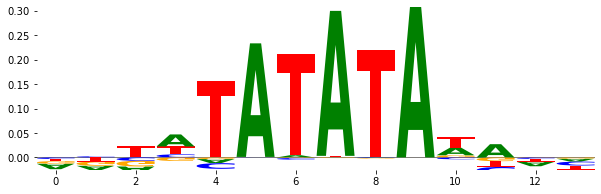

In [19]:
plot_weights(test_pattern["trimmed_cwm_fwd"])

In [ ]:
plot_weights(test_pattern["cwm_fwd"], save=os.path.join(modisco_out, "test_pattern_cwm_fwd.png"))

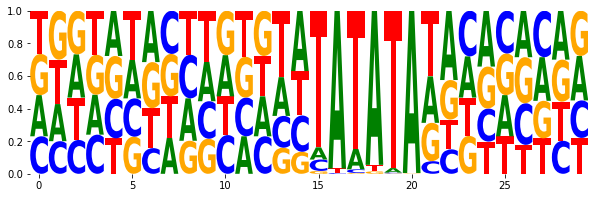

Output directory already exists: /cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out


<Figure size 432x288 with 0 Axes>

In [20]:
plot_weights(test_pattern["ppm"], save=os.path.join(modisco_out, "test_pattern_ppm.png"))

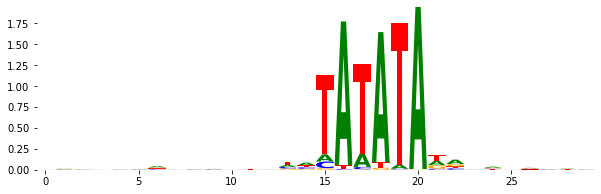

Output directory already exists: /cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out


<Figure size 432x288 with 0 Axes>

In [24]:
plot_weights(test_pattern["ppm"], pwm=True, save=os.path.join(modisco_out, "test_pattern_pwm.png"))

In [183]:
background = np.array([0.25, 0.25, 0.25, 0.25])
fetch_tomtom_matches(
    ppm=test_pattern["ppm"],
    cwm=test_pattern["cwm_fwd"],
    motifs_db=meme_db,
    background=background,
    tomtom_exec_path=tomtom_exec,
    trim_threshold=0.3,
    trim_min_length=3
)

,Target_ID,q-value
0,TATA,0.019586
1,Inr,1.000000
2,TCT,1.000000
3,POL007.1,1.000000
4,POL006.1,1.000000
5,Ypatch,1.000000
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN


---

# Scratch

In [142]:
from seqexplainer._seq import decode_seqs

In [144]:
#seqlet_seqs = decode_seqs(pattern["seqlets"]["sequence"][:].transpose(0, 2, 1))

Decoding sequences:   0%|          | 0/355 [00:00<?, ?it/s]

In [6]:
import os
from modiscolite.io import save_hdf5
from modiscolite.report import read_meme, compute_per_position_ic, write_meme_file, fetch_tomtom_matches, run_tomtom, make_logo, create_modisco_logos, report_motifs

In [72]:
meme_file = "/cellar/users/aklie/opt/meme-5.5.0/db/motif_databases/ARABD/ArabidopsisDAPv1.meme"
output_dir = "/cellar/users/aklie/projects/SeqExplainer/notebooks/implement/modisco_out/"
modisco_logo_dir = output_dir + '/trimmed_logos/'
if not os.path.exists(modisco_logo_dir):
    os.makedirs(modisco_logo_dir)
suffix = "./"
top_n_matches = 3
trim_threshold=0.3
trim_min_length=3

In [75]:
save_hdf5(os.path.join(output_dir, "jores21_leaf_modisco.h5"), pos_patterns, neg_patterns)

In [ ]:
motifs = read_meme(meme_file)

In [98]:
create_modisco_logos?

Signature: create_modisco_logos(modisco_file, modisco_logo_dir, trim_threshold)
Docstring: <no docstring>
File:      ~/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/modiscolite/report.py
Type:      function


In [74]:
names = create_modisco_logos(
    os.path.join(output_dir, "jores21_leaf_modisco.h5"),
    modisco_logo_dir=modisco_logo_dir,
    trim_threshold=0.3
)

In [99]:
run_tomtom?

Signature:
run_tomtom(
    modisco_h5py,
    output_prefix,
    meme_motif_db,
    top_n_matches=3,
    tomtom_exec='tomtom',
    trim_threshold=0.3,
    trim_min_length=3,
)
Docstring: <no docstring>
File:      ~/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/modiscolite/report.py
Type:      function


In [78]:
tomtom_df = run_tomtom(
    os.path.join(output_dir, "jores21_leaf_modisco.h5"),
    output_prefix="tomtom_out", 
    meme_motif_db=meme_file, 
    tomtom_exec="~/opt/meme/bin/tomtom"
)

In [79]:
tomtom_df

,pattern,num_seqlets,match0,qval0,match1,qval1,match2,qval2
0,pos_patterns.pattern_0,728,ARID_tnt.AT1G04880_col_a_m1,1.000000,ARID_tnt.AT1G04880_colamp_a_m1,1.000000,MYB_tnt.MYB56_col_a_m1,1.000000
1,pos_patterns.pattern_1,67,CPP_tnt.TSO1_col_a_m1,0.301344,CPP_tnt.SOL1_col_m1,0.301344,CPP_tnt.AT2G20110_col_a_m1,0.301344
2,pos_patterns.pattern_2,40,Trihelix_tnt.GT2_colamp_a_m1,0.772910,Trihelix_tnt.AT1G76880_col_a_m1,0.772910,Trihelix_tnt.GT2_col_a_m1,0.772910
3,neg_patterns.pattern_0,45,Trihelix_tnt.AT3G58630_col_a_m1,0.179240,Trihelix_tnt.AT3G58630_colamp_a_m1,0.179240,Trihelix_tnt.AT5G05550_col_a_m1,0.179240
4,neg_patterns.pattern_1,30,AP2EREBP_tnt.RAP211_col_a_m1,0.011300,AP2EREBP_tnt.ESE1_col_a_m1,0.011300,AP2EREBP_tnt.CRF4_colamp_a_m1,0.011300
5,neg_patterns.pattern_2,28,AP2EREBP_tnt.ERF104_col_a_m1,0.154545,AP2EREBP_tnt.ABR1_col_a_m1,0.154545,AP2EREBP_tnt.LEP_col_a_m1,0.154545
6,neg_patterns.pattern_3,24,bHLH_tnt.bHLH34_colamp_a_m1,1.000000,G2like_tnt.At3g24120_col_a_m1,1.000000,C2C2gata_tnt.GATA12_colamp_a_m1,1.000000


In [102]:
report_motifs?

Signature:
report_motifs(
    modisco_h5py,
    output_dir,
    meme_motif_db,
    suffix='./',
    top_n_matches=3,
    trim_threshold=0.3,
    trim_min_length=3,
)
Docstring: <no docstring>
File:      ~/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/modiscolite/report.py
Type:      function


In [81]:
report_motifs(
    os.path.join(output_dir, "jores21_leaf_modisco.h5"),
    output_dir=os.path.join(output_dir, "report"),
    meme_motif_db=meme_file
)

In [ ]:
cwm_fwd = metacluster.contrib_scores
cwm_rev = cwm_fwd[::-1, ::-1]
score_fwd = np.sum(np.abs(cwm_fwd), axis=1)
score_rev = np.sum(np.abs(cwm_rev), axis=1)

trim_thresh_fwd = np.max(score_fwd) * trim_threshold
trim_thresh_rev = np.max(score_rev) * trim_threshold

pass_inds_fwd = np.where(score_fwd >= trim_thresh_fwd)[0]
pass_inds_rev = np.where(score_rev >= trim_thresh_rev)[0]

start_fwd, end_fwd = max(np.min(pass_inds_fwd) - 4, 0), min(np.max(pass_inds_fwd) + 4 + 1, len(score_fwd) + 1)
start_rev, end_rev = max(np.min(pass_inds_rev) - 4, 0), min(np.max(pass_inds_rev) + 4 + 1, len(score_rev) + 1)

trimmed_cwm_fwd = cwm_fwd[start_fwd:end_fwd]
trimmed_cwm_rev = cwm_rev[start_rev:end_rev]

In [ ]:
def path_to_image_html(path):
    return '<img src="'+ path + '" width="240" >'

import pandas
tomtom_df['modisco_cwm_fwd'] = ['{}trimmed_logos/{}.cwm.fwd.png'.format(suffix, name) for name in names]
tomtom_df['modisco_cwm_rev'] = ['{}trimmed_logos/{}.cwm.rev.png'.format(suffix, name) for name in names]

reordered_columns = ['pattern', 'num_seqlets', 'modisco_cwm_fwd', 'modisco_cwm_rev']
for i in range(top_n_matches):
    name = "match{}".format(i)
    logos = []

    for index, row in tomtom_df.iterrows():
        if name in tomtom_df.columns:
            if pandas.isnull(row[name]):
                logos.append("NA")
            else:
                make_logo(row[name], output_dir, motifs)
                logos.append("{}{}.png".format(suffix, row[name]))
        else:
            break

    tomtom_df["{}_logo".format(name)] = logos
    reordered_columns.extend([name, 'qval{}'.format(i), "{}_logo".format(name)])

tomtom_df = tomtom_df[reordered_columns]
tomtom_df.to_html(open('{}/motifs.html'.format(output_dir), 'w'),
    escape=False, formatters=dict(modisco_cwm_fwd=path_to_image_html,
        modisco_cwm_rev=path_to_image_html, match0_logo=path_to_image_html,
        match1_logo=path_to_image_html, match2_logo=path_to_image_html), 
    index=False)

In [77]:
%%bash
export PATH=/cellar/users/aklie/opt/meme/bin:/cellar/users/aklie/opt/meme/libexec/meme-5.5.0:$PATH
tomtom --help

tomtom: unrecognized option '--help'

Usage:
  tomtom [options] <query file> <target file>+
Options:
  -o <output dir>  Name of directory for output files;
                    will not replace existing directory
  -oc <output dir> Name of directory for output files;
                    will replace existing directory
  -xalph           Convert the alphabet of the target motif databases
                    to the alphabet of the query motif database
                    assuming the core symbols of the target motif
                    alphabet are a subset; default: reject differences
  -bfile <background file>
                   Name of background file;
                    default: use the background from the query
                    motif database
  -motif-pseudo <pseudo count>
                   Apply the pseudocount to the query and target motifs;
                    default: apply a pseudocount of 0.1
  -m <id>          Use only query motifs with a specified id;
                   

CalledProcessError: Command 'b'export PATH=/cellar/users/aklie/opt/meme/bin:/cellar/users/aklie/opt/meme/libexec/meme-5.5.0:$PATH\ntomtom --help\n'' returned non-zero exit status 1.

In [ ]:
!tomtom

/bin/bash: tomtom: command not found


In [ ]:
modiscolite.report.report_motifs(
    args.h5py, 
    args.output, 
    suffix=args.suffix, 
    top_n_matches=args.n_matches,
    meme_motif_db=args.meme_db
)

In [ ]:
from modiscolite.report import create_modisco_logos

In [ ]:
import os
from modiscolite.tfmodisco import TFMoDISco
TFMoDISco?

In [ ]:
import matplotlib.pyplot as plt
import pandas
import logomaker
def _plot_weights(array, figsize=(10,3), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    df = pandas.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded')
    crp_logo.style_spines(visible=False)
    plt.ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())

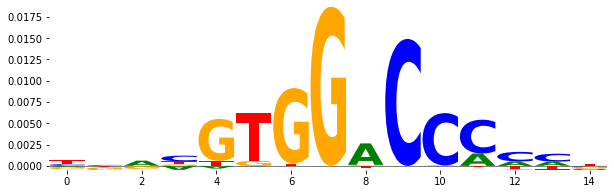

In [ ]:
_plot_weights(trimmed_cwm_fwd)

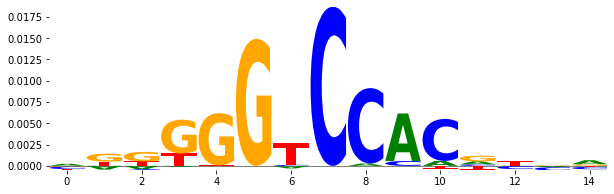

In [ ]:
_plot_weights(trimmed_cwm_rev)